In [41]:
import import_ipynb
import datetime as dt
import pandas as pd
import numpy as np
import requests
import string

from bs4 import BeautifulSoup

import sklearn

import twint 
import nest_asyncio
nest_asyncio.apply()

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 


## Understanding and Visualising the data

In [42]:
# Understanding the data
df = pd.read_csv('all-data.csv', encoding = "ISO-8859-1")
df.head()

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


Data comprised of headlines. and three labels - neutral, positive or negative.

In [43]:
# Data Cleaning
df = df.rename(columns={'neutral':'sentiment','According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .':'headlines'})

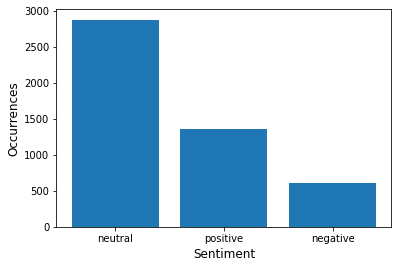

In [44]:
# Visualising data
data = df['sentiment'].value_counts()
plt.bar(data.index, data.values)
plt.ylabel('Occurrences', fontsize=12)
plt.xlabel('Sentiment', fontsize=12)
plt.show()

## Cleaning and Tokenizing data

- Remove any punctuation and turn all data into a lowercase format to make it suitable for lematization and analysis.
- Break down headlines into its individual words

In [45]:
#Convert categories to numeric
sentiment  = {'positive': 0,'neutral': 1,'negative': -1} 

df.sentiment = [sentiment[label] for label in df.sentiment]

In [46]:
# Cleaning headlines 
def clean_data(df):
    clean_headlines = df.apply(lambda headlines: headlines.lower().translate(str.maketrans('', '', string.punctuation)))
    return clean_headlines
    
# Tokenize data
def tokenize_data(df):
    tokenized_headlines = df.apply(lambda headline: headline.split())
    return tokenized_headlines

### Lemmatization
- Lemmatization is a way to normalize text data. It links words with similar meanings to one word.
- The lemma of a set of words is its dictionary form. For example, [break, breaks, broke, broken] are all indexed by the lemma 'break'. 
- By using lematization, all the words in headlines are reduced to their lemma which makes it much more useful for analysis

In [47]:
lemmatizer = WordNetLemmatizer()

def lemmatize_data(df):
    # Analyses the tokenized headline and returns the list in its lematized form
    def lemmatize_headline(headline):
        lemmas = [lemmatizer.lemmatize(word) for word in headline]
        return headline
    return df.apply(lemmatize_headline)

### Stop Words
- Stop words are the most common words in the language.
- Since these words are normally irrelevant, they should be removed. 
- However, it should be noted that certain words such as But, And, etc may be relevant to sentiment analysis

In [48]:
def remove_stopwords_data(df):
    stop_words = stopwords.words('english')
    # Removes stop words from each headline
    def remove_stopwords_headline(headline):
        headline = [word for word in headline if word not in stop_words]
        return ' '.join(headline)
    return df.apply(remove_stopwords_headline)

In [49]:
# Lastly, filter neutral news:
df = df[df['sentiment'] != 0]

## Preprocessing Data

In [50]:
from sklearn.model_selection import train_test_split

# Preprocessing - Done this way for demonstration purposes

# clean data from training data
df['clean_data'] = clean_data(df['headlines'])
# tokenize data from training data
df['tokenize_data']  = tokenize_data(df['clean_data'])
# lemmatize data from training data
df['lemmatize_data']  = lemmatize_data(df['tokenize_data'])
# remove stop words from training data
df['processed_data']  = remove_stopwords_data(df['lemmatize_data'])
# Lastly, filter neutral news:
df = df[df['sentiment'] != 0]

## Split into training and test set

In [51]:
# We only require the processed data 
df = df[['sentiment','processed_data']]

# Splitting into training and test data
data, label = df['processed_data'], df['sentiment']

x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.2, random_state=42,stratify=label)

## TensorFlow Tokenizer
- TensorFlow's Tokenizer package allows us to turn each text into a sequence of integers suitable for data analysis. The integer returned is based on the number of instances of that word in that dataset. 
- We use this to allow our data to be used in machine learning algorithms

In [63]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
max_features = 1000

# Tokenization 
tokenizer = Tokenizer(num_words=max_features, oov_token = "<OOV>") 
# creates a vocabulary index based on word frequency using training dataset
tokenizer.fit_on_texts(data)
# All unique words are given an index:
word_index = tokenizer.word_index

In [53]:
# transforms each word using its respective value in the vocabulary index 
# to produce a sequence of numbers.
training_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

# padding transforms the sequence into a 2D Numpy array to allow us to
# use the data to train the models
training_padded = pad_sequences(training_sequences, padding = 'post')
test_padded = pad_sequences(test_sequences, padding = 'post')

# unique tokens
vocab_size = len(training_padded) 
training_padded.shape # 3482 sequences, each with 38 tokens

(2785, 47)

In [54]:
#setting a threshold for the number of words in each text
num_tokens=[len(tokens) for tokens in training_sequences+test_sequences]
num_tokens=np.array(num_tokens)
max_tokens=np.mean(num_tokens)+2*np.std(num_tokens)
max_tokens=int(max_tokens)

# Applying Machine Learning model

In [55]:
# import machine learning models
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Neural Network

### Turns vocabulary index into vectors of fixed size.
<code>     
tf.keras.layers.Embedding(vocab_size, embedding_dim, input_legnth = max_length)
</code>

Parameter breakdown:
1) Vocab size is the largest integer in the word index that the model will take.

2) Size of the vector space in which the words will be embedded.

3) Length of the input sequences (set to 1000 to take largest headlines)

In [56]:
import tensorflow as tf

notes:
    how many layers in the middle? usually 1
    how many nodes in hidden layer? midway between input and output
    activation function -> introduces non-linearity 
    learning rate -> how much does the step affect our weight/bias
    momentum -> how much past outcomes affect weight/bias
    iterations and desired error level

In [57]:
# input dimensions
training_padded.shape # 2437 sequences, each with 47 tokens

(2785, 47)

In [65]:
max_features = 1000
embedding_size=50 
max_tokens

25

In [69]:
model= tf.keras.Sequential()

# Embedding layer will take text as input, convert it to a vector as output
model.add(tf.keras.layers.Embedding(input_dim = max_features,
                   output_dim = embedding_size,
                    input_length = max_tokens,
                    name = 'embedding_layer'
                   ))

In [78]:
model.add(tf.keras.layers.GRU(units=16, # number of neurons 
              return_sequences=True) # if true this layer odel creates multiple outputs. If the following layer has one neuron, which means the following layer creates the output. 
)
model.add(tf.keras.layers.GRU(units=8, return_sequences=True))
model.add(tf.keras.layers.GRU(units=4))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))#with the sigmoid activation function, we receive an output between 0 and 1.
optimizer=Adam(lr=1e-3)

ValueError: Input 0 of layer "gru_6" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 4)

In [59]:

model = tf.keras.Sequential([
    # learns the direction of each word epoch by epoch
    tf.keras.layers.Embedding(vocab_size, embedding_size, input_length = max_tokens),
    # pool using global average
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(47, activation = 'relu'),
    tf.keras.layers.Dense(1, activation ='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [60]:
result = model.fit(training_padded, y_train, epochs = 30, validation_data = (test_padded, y_test), verbose = 2)

Epoch 1/30


ValueError: in user code:

    File "C:\Users\nurul\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\nurul\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\nurul\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\nurul\anaconda3\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\nurul\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\nurul\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 25), found shape=(None, 47)


## Building Logistic Regression Model

In [ ]:
lr = LogisticRegression(max_iter = 2000, solver = 'lbfgs')
lr.fit(x_train, y_train)

In [ ]:
https://towardsdatascience.com/sentiment-analysis-using-logistic-regression-and-naive-bayes-16b806eb4c4b

In [ ]:
def sigmoid(z): 
    '''
    Input:
        z: is the input (can be a scalar or an array)
    Output:
        h: the sigmoid of z
    '''
    # calculate the sigmoid of z
    h = 1/(1 + np.exp(-z))
    
    return h

In [ ]:
def gradientDescent(x, y, theta, alpha, num_iters):
    '''
    Input:
        x: matrix of features which is (m,n+1)
        y: corresponding labels of the input matrix x, dimensions (m,1)
        theta: weight vector of dimension (n+1,1)
        alpha: learning rate
        num_iters: number of iterations you want to train your model for
    Output:
        J: the final cost
        theta: your final weight vector
    Hint: you might want to print the cost to make sure that it is going down.
    '''
    
    m = len(x)
  
    for i in range(0, num_iters):
        
        # get z, the dot product of x and theta
        z = np.dot(x,theta)
        
        # get the sigmoid of z
        h = sigmoid(z)
        
        # calculate the cost function
        J = (-1/m)*(np.dot(y.T,np.log(h)) + np.dot((1-y).T,np.log(1-h)))
        
        # update the weights theta
        theta = theta - (alpha/m)*np.dot(x.T, h-y)
        
    J = float(J)
    return J, theta

In [ ]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet
        freqs: a dictionary corresponding to the frequencies of each tuple (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = process_tweet(tweet)
    
    # 3 elements in the form of a 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    #bias term is set to 1
    x[0,0] = 1 
        
    # loop through each word in the list of words
    for word in word_l:
        
        # increment the word count for the positive label 1
        x[0,1] += freqs.get((word,1),0)
        
        # increment the word count for the negative label 0
        x[0,2] += freqs.get((word,0),0)
        
    assert(x.shape == (1, 3))
    return x

In [ ]:
def word_freq(df):
    hash_map = {}
    for headline in df:
        for word in headline:
            if word in hash_map:
                hash_map[word] += 1
            else:
                hash_map[word] = 0
    return hash_map

word_freq(x_train['final'])
word_freq(x_test['final'])

In [ ]:
# Gets news headlines from popular sites

def news_fetch(query):
    return

# Gets popular tweets from twitter

def twitter_fetch(query):
    c = twint.Config()
    
    c.Search = query
    c.Lang = 'en'
    c.Hide_output = True
    c.Pandas = True
    c.Min_likes = 100
    c.Limit = 5000
    twint.run.Search(c)
    data = twint.storage.panda.Tweets_df

    return data

In [ ]:
clean_data = []
for source in positive:
    for tweet in source:
        clean_data.append(tweet.lower().translate(str.maketrans('', '', string.punctuation)))
        
len(clean_data)

In [ ]:
def clean_data(df):
    # removes punctuation and turns tweets to lower case
    clean_data = df.apply(lambda tweet: tweet.lower().translate(str.maketrans('', '', string.punctuation)))

In [ ]:
clean_negative = clean_data(negative)
clean_positive = clean_data(positive)

In [ ]:
# DataFrame
pd.DataFrame(hashmap_negative.values(), index = hashmap_negative).sort_values(by = 0, ascending=False)



In [ ]:
def get_sentiment():
    return

def average_sentiment_score():
    return

In [ ]:
negative = twitter_fetch("(inflation OR market underperform)")
negative

In [ ]:
'towardsdatascience.com/5-ways-to-develop-a-sentiment-analyser-in-machine-learning-e8352872118'


In [ ]:
# test dataset

# list of negative sentiment words: from github/mkulakowski2
with open('positive-words.txt') as file:
    positive = [x.strip('\n') for x in file]
    
# list of positive sentiment words:
with open('negative-words.txt') as file:
    negative = [x.strip('\n') for x in file]